# Neural Network Trading Bot 

Using historical stock data, we build a LSTM model to classify whether to buy, sell, or hold.

Note: this project is for educational purposes only.

## Import Libraries

In [ ]:
import pandas as pd                      # Pandas
import numpy as np                       # Numpy
import ta                                # Technical analysis
from psequant import get_pse_data        # Get Philippine Stock Exchange (PSE) data
import warnings                          # Ignore warnings
import matplotlib.pyplot as plt          # Plotting
import tensorflow as tf                  # Tensorflow

from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM, Bidirectional, BatchNormalization, Reshape, LeakyReLU
from keras.models import Sequential
from keras.metrics import CategoricalAccuracy

pd.set_option('display.max_rows', None)
warnings.filterwarnings("ignore")

# gpus = tf.config.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

## Function Implementation

In [2]:
def get_ta(df):
    """ Add commonly used technical indicators to features using the TA library
    """

    df['EMA10'] = ta.trend.EMAIndicator(df['close'], window = 10).ema_indicator()
    df['EMA20'] = ta.trend.EMAIndicator(df['close'], window = 20).ema_indicator()
    df['EMA50'] = ta.trend.EMAIndicator(df['close'], window = 50).ema_indicator()
    df['EMA100'] = ta.trend.EMAIndicator(df['close'], window = 100).ema_indicator()

    df['MA10'] = ta.trend.SMAIndicator(df['close'], window = 10).sma_indicator()
    df['MA20'] = ta.trend.SMAIndicator(df['close'], window = 20).sma_indicator()
    df['MA50'] = ta.trend.SMAIndicator(df['close'], window = 50).sma_indicator()
    df['MA100'] = ta.trend.SMAIndicator(df['close'], window = 100).sma_indicator()

    df['ADX'] = ta.trend.ADXIndicator(df['high'], df['low'], df['close']).adx()

    macd_hist = ta.trend.MACD(df['close'])
    df['MACD Diff'] = macd_hist.macd_diff()
    df['MACD Line'] = macd_hist.macd()
    df['Signal Line'] = macd_hist.macd_signal()

    df['RSI'] = ta.momentum.rsi(df['close'])

    return df 

In [3]:
def get_classification(df, lag = 15, threshold = 1):    
    """ Get the classification of each candle stick based on next close.
        We want to classify breakouts (Buy), breakdowns (Sell), and consolidations (Hold).
        We base the classification on some support and resistance lines.
    """

    df['upper'] = df.apply(lambda df: max(df['close'], df['open']), axis = 1)
    df['lower'] = df.apply(lambda df: min(df['close'], df['open']), axis = 1)
    df['max_upper'] = df['upper'].rolling(window=lag).max()
    df['min_lower'] = df['lower'].rolling(window=lag).max()

    df['next_close'] = df['close'].shift(-1)
    df.dropna(inplace = True)
    
    df['breakout'] = df.apply(lambda df: 
            1 if df['next_close'] > (1 + threshold / 100) * df['max_upper'] else 0, 
            axis = 1)
    df['breakdown'] = df.apply(lambda df:
            1 if df['next_close'] < (1 - threshold / 100) * df['min_lower'] else 0,
            axis = 1)
    df['consolidating'] = 1 - df['breakout'] - df['breakdown']

    return df.drop(['next_close', 'upper', 'lower', 'max_upper', 'min_lower'], axis = 1)

In [4]:
def split_io(df, lag = 15):
    input = []
    output = [] 
    
    for index in range(lag,df.shape[0]):
        input.append(
            np.array(
                df.drop(['consolidating', 'breakout', 'breakdown'], axis = 1)[index - lag : index]
            )
        )
        output.append(
            np.array(
                df[['consolidating', 'breakout', 'breakdown']][index - 1 : index]
            )
        )

    return np.array(input), np.array(output)

In [5]:
def get_splitted_data(df, split = 100):
    df = get_ta(df)
    df = get_classification(df)
    if 'dt' in df.columns:
        df.drop('dt', axis = 1, inplace = True)
    input, output = split_io(df)
    
    train_input = input[:-split]
    train_output = output[:-split]
    test_input = input[-split:]
    test_output = output[-split:]
    
    return train_input, train_output, test_input, test_output

In [6]:
def plot_fit(model_fit):
    plt.plot(model_fit.history['accuracy'])
    plt.plot(model_fit.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc = 'upper left')
    plt.show()
    
    plt.plot(model_fit.history['loss'])
    plt.plot(model_fit.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc = 'upper left')
    plt.show()

## Building and Training the Model

Using `get_pse_data`, we get historical stock data. We then split the data into training and test data using `get_splitted_data`.

In [7]:
df = get_pse_data('JFC', '2000-01-01', '2022-12-31')
train_input, train_output, test_input, test_output = get_splitted_data(df)
print(f"Input shape: {train_input[0].shape}")
print(f"Output shape: {train_output[0].shape}")

Stock table exists!
Reading stock_table.csv ...
Input shape: (15, 18)
Output shape: (1, 3)


We built an LSTM model.

In [8]:
window_size = 50
dropout = 0.1

model = Sequential()

model.add(BatchNormalization(input_shape=train_input[0].shape))
model.add(Reshape((1,-1)))

model.add(Bidirectional(LSTM(window_size, return_sequences = True)))
model.add(Activation('sigmoid'))
model.add(Dropout(dropout))

model.add(Bidirectional(LSTM(window_size, return_sequences = True)))
model.add(Activation('sigmoid'))
model.add(Dropout(dropout))

model.add(Bidirectional(LSTM(window_size, return_sequences = True)))
model.add(Activation('sigmoid'))
model.add(Dropout(dropout))

model.add(Dense(units = window_size))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(dropout))
model.add(BatchNormalization())

model.add(Dense(units = window_size))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(dropout))

model.add(Dense(units = window_size))
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(units = window_size))
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(units = 3, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', 
        metrics = ['accuracy'])

model.summary()

2022-06-17 14:44:10.572161: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:59:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-06-17 14:44:10.609060: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:59:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-06-17 14:44:10.609867: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:59:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-06-17 14:44:10.610502: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 15, 18)           72        
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 1, 270)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 1, 100)           128400    
 l)                                                              
                                                                 
 activation (Activation)     (None, 1, 100)            0         
                                                                 
 dropout (Dropout)           (None, 1, 100)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 1, 100)           6

In [9]:
model_fit = model.fit(train_input, train_output, epochs = 50, validation_split = 0.2)

Epoch 1/50


2022-06-17 14:44:21.582952: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


70/70 [==============================] - 15s 67ms/step - loss: 0.8827 - accuracy: 0.5687 - val_loss: 0.9132 - val_accuracy: 0.7058
Epoch 2/50
70/70 [==============================] - 3s 41ms/step - loss: 0.8565 - accuracy: 0.5863 - val_loss: 0.8562 - val_accuracy: 0.7058
Epoch 3/50
70/70 [==============================] - 3s 39ms/step - loss: 0.8461 - accuracy: 0.5808 - val_loss: 0.8739 - val_accuracy: 0.7058
Epoch 4/50
70/70 [==============================] - 3s 38ms/step - loss: 0.8557 - accuracy: 0.5822 - val_loss: 0.8622 - val_accuracy: 0.7058
Epoch 5/50
70/70 [==============================] - 3s 37ms/step - loss: 0.8547 - accuracy: 0.5885 - val_loss: 0.8744 - val_accuracy: 0.7058
Epoch 6/50
70/70 [==============================] - 3s 38ms/step - loss: 0.8499 - accuracy: 0.5876 - val_loss: 0.8495 - val_accuracy: 0.7058
Epoch 7/50
70/70 [==============================] - 2s 35ms/step - loss: 0.8423 - accuracy: 0.5921 - val_loss: 0.8178 - val_accuracy: 0.7058
Epoch 8/50
70/70 [=====

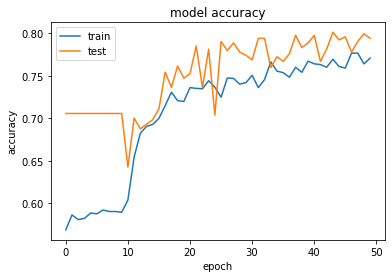

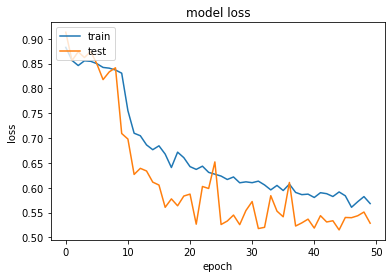

In [10]:
plot_fit(model_fit)

We check the performance of our model against the test data.

In [11]:
predictions = model.predict(test_input)
m = CategoricalAccuracy()
m.update_state(test_output, predictions)
print(f"Accuracy: {m.result().numpy()}")

4/4 [==============================] - 2s 26ms/step
Accuracy: 0.8399999737739563
